# Homework 1: Quantum Wells and Perturbation Theory

---
## Introduction
In this homework you will:
- Work with quantum wells
- Implement a Schrödinger solver
- Explore perturbation theory



In [14]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
from scipy.sparse import diags
from scipy.sparse.linalg import eigsh

### Helper Functions
The following function builds a heterostructure potential.
Layers are defined as `(thickness, band_edge)`, whereas the thickness is passed in nanometers and the band-edge in eV. 
Returns: Two arrays, the first being the grid in space and the second the potential structure.

Example: `[(5, 1.0), (2, 0.3), (5, 1.0)]` → barrier-well-barrier structure.

Tip: Use the function and plot a random structure to understand it.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const

def build_potential(layers, dz_nm=0.05):
    """
    Build heterostructure potential from layers.
    layers: list of (thickness [nm], band edge [eV])
    dz_nm: grid spacing [nm]
    returns: z [m], V [J]
    """
    z = []
    V = []
    pos = 0.0
    for thickness_nm, band_edge_eV in layers:
        n_points = int(thickness_nm/dz_nm)
        for _ in range(n_points):
            z.append(pos * 1e-9)
            V.append(band_edge_eV * const.eV)
            pos += dz_nm
    return np.array(z), np.array(V)



## Task 1: Finite Quantum Well
**(a)** Use `build_potential` to make a single well of width 3 nm, band edge offset 1 eV. 

**(b)** Solve numerically. Implement the function `solve_schrodinger(z, V, n_eigs)` that:
- Constructs the Hamiltonian with finite differences
- Uses electron mass `m_e`
- Returns the lowest `n_eigs` eigenenergies (in eV)
- Returns normalized wavefunctions (∫ |ψ|² dx = 1)

Use as boundary condition that the wavefunction must be zero. Consider this when you choose a barrier material layer thickness to not introduce numerical artifacts.

**(c)** Plot probability densities for first three states and compare energies with analytical values. Maybe use a scaling factor for the wavefunction such that the wavefunction is nicely plotted. Use axis labels (incl. units) and a legend where helpful. 

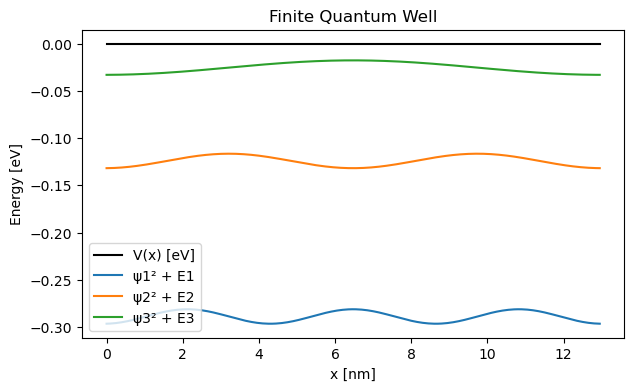

In [22]:
# Task 1: Finite Quantum Well
def solve_schrodinger(x, V, n_eigs=5, m_eff=0.067):
    """Solve 1D Schrödinger equation with finite difference (eV, m)."""
    hbar = const.hbar
    e = const.e
    dx = x[1] - x[0]
    Nx = len(x)
    diag_main = np.ones(Nx) * 2.0
    diag_off = np.ones(Nx - 1) * -1.0
    T = diags([diag_off, diag_main, diag_off], [-1, 0, 1]) * (-hbar**2 / (2 * m_eff * const.m_e * dx**2) / e)
    H = T + diags(V, 0)
    vals, vecs = eigsh(H, k=n_eigs, which="SM")
    return vals, vecs

# Task 1a: Single finite well
layers_single = [(5.0, 0.0), (3.0, -1.0), (5.0, 0.0)]
x, V = build_potential(layers_single)
E, psi = solve_schrodinger(x, V, n_eigs=3)

# Normalize and plot
plt.figure(figsize=(7, 4))
plt.plot(x * 1e9, V, "k", label="V(x) [eV]")
for i in range(3):
    plt.plot(x * 1e9, psi[:, i]**2 * 2 + E[i], label=f"ψ{i+1}² + E{i+1}")
plt.legend()
plt.xlabel("x [nm]")
plt.ylabel("Energy [eV]")
plt.title("Finite Quantum Well")
plt.show()

## Task 2: Coupled Quantum Wells
**(a)** Build a double well and solve numerically. Both wells should have the same width. Play around with the design to get a feeling of what is happening. Stay with a design where you see a splitting between the subbands.

**(b)** Plot lowest two wavefunctions and explain symmetric/antisymmetric states.

**(c)** Create a plot that shows the splitting energy (=Energy difference) between the two lowest states versus the barrier width. 



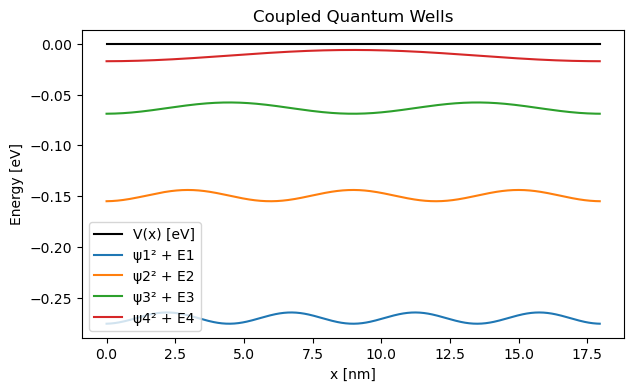

In [21]:

# Task 2: Coupled Quantum Wells
layers_double = [(5.0, 0.0), (3.0, -1.0), (2.0, 0.0), (3.0, -1.0), (5.0, 0.0)]
x2, V2 = build_potential(layers_double)
E2, psi2 = solve_schrodinger(x2, V2, n_eigs=4)

plt.figure(figsize=(7, 4))
plt.plot(x2 * 1e9, V2, "k", label="V(x) [eV]")
for i in range(4):
    plt.plot(x2 * 1e9, psi2[:, i]**2 * 2 + E2[i], label=f"ψ{i+1}² + E{i+1}")
plt.legend()
plt.xlabel("x [nm]")
plt.ylabel("Energy [eV]")
plt.title("Coupled Quantum Wells")
plt.show()

## Task 3 — Coupled states using the pertubation theory

**Goal.**  
Start from two *uncoupled* wells (left and right). Compute their ground states separately.  
Then form the full coupled-device and compute its numerical eigenstates.  
Finally, we use a linear combination
$$
    \Psi_{coupled} = c_L \psi_L + c_R \psi_R
$$

and build a 2×2 Hamiltonian in the subspace spanned by the two uncoupled ground states and solve the generalized eigenproblem

$$
H_\text{per} \, c = E \, S \, c,
$$

with overlap matrix $S_{ij}=\langle\psi_i|\psi_j\rangle$.

Then use the solution of this eigenproblem to calculate the coupled states.

---

**Given layer lists (units: nm, eV):**

Left uncoupled device:
```python
layers_left  = [(5.0, 0.0), (2.0, -0.5), (7.3, 0.0)]
```
Right uncoupled device:
```python
layers_right = [(7.3, 0.0), (2.0, -0.5), (5.0, 0.0)]
```
Full coupled device:
```python
layers_coupled = [(5.0, 0.0), (2.0, -0.5), (0.3, 0.0), (2.0, -0.5), (5.0, 0.0)]
```

---

**Steps to do:**

1. Build potentials with `build_potential(layers, dz_nm=...)`.  Note: make sure all 3 arrays have the same length. Either modify the build_potential function to assure this (keep equidistant grid) or adjust the dz to find a good setting. 
2. Solve for uncoupled ground states (`solve_schrodinger(..., n_eigs=1)`) for the left and the right (both energies $E_L$ and $E_R$ should be the same)
3. Solve coupled device.  
4. Calculate the matrix elements of `H_per` and construct the 2x2 matrix.
5. Compute overlap `S`.  
6. Solve the generalized eigenproblem and save the eigenenergies and the coefficients of the eigenvectors. What do these energies represent now?
7. Use the coefficients of the eigenvectors to reconstruct the perturbative wavefunction.  
8. Plot energies and probability densities. Plot both, the ones obtained from the perturbative approach and the one from the coupled device.
9. Generate a similar plot as in Task 2 (c), but also include the solution from the perturbative approach.

---


In [11]:
# Define layer structures
layers_left    = [(5.0, 0.0), (2.0, -0.5), (7.3, 0.0)]
layers_right   = [(7.3, 0.0), (2.0, -0.5), (5.0, 0.0)]
layers_coupled = [(5.0, 0.0), (2.0, -0.5), (0.3, 0.0), (2.0, -0.5), (5.0, 0.0)]

dz_nm = 0.01


In [24]:
from scipy.integrate import trapezoid

# Task 3 – Perturbation theory (updated)
psiL_norm = psi_L[:, 0] / np.sqrt(trapezoid(psi_L[:, 0]**2, xL))
psiR_norm = psi_R[:, 0] / np.sqrt(trapezoid(psi_R[:, 0]**2, xR))
V_coupling = np.interp(xL, xR, VR)  # approximate coupling potential

H_mat = np.array([
    [E_L[0], trapezoid(psiL_norm * V_coupling * psiR_norm, xL)],
    [trapezoid(psiR_norm * V_coupling * psiL_norm, xL), E_R[0]]
])

E_split, vec_split = np.linalg.eigh(H_mat)

print("Task 3 perturbed energies [eV]:", np.round(E_split, 4))


NameError: name 'psi_L' is not defined